NVIDIA Jetson devices provide powerful AI inference capabilities at the edge, and with the right setup, you can efficiently run deep learning models like ResNet18 using the FastAI library. In this tutorial, we will use an [NVIDIA® Jetson Orin Nano™ Developer Kit](https://developer.nvidia.com/embedded/learn/jetson-orin-nano-devkit-user-guide/index.html) to fine-tune a ResNet18 model on Imagenette-320, a smaller dataset derived from ImageNet, but with 320x320 resolution images.

## Installation

**Software and Package Versions**

This guide involves the following software and package versions for setting up PyTorch on the Jetson Orin Nano:

- **JetPack** - 6.2 (also compatible with 6.1)  
- **CUDA** - 12.6  
- **Python** - 3.10  
- **cuSPARSELt** - 0.7.0  
- **torch** - 2.5.0a0+872d972e41 ([NVIDIA wheel](https://developer.download.nvidia.com/compute/redist/jp/v61/pytorch)).  
- **torchvision** - 0.20.0 (built from source)  
- **spacy** - 3.7.2  
- **fastai** - 2.7.18  

Follow our [previous guide](jetson_pytorch.ipynb) to setup CUDA and PyTorch on Jetson devices. Ensure PyTorch and torchvision were installed first to avoid version conflicts, and note that FastAI version 2.7.18 requires torch < 2.6. Then, install FastAI and dependencies:

```sh
$ pip install spacy==3.7.2
$ pip install fastai
```

**Troubleshooting**: spacy version 3.7.2 should be installed first because building wheel for spacy version 3.8.3 currently fails on this architecture.

After installation, FastAI utilities can now be imported into your workspace:

In [1]:
from fastai.vision.all import *

## Dataset

Imagenette2-320 is a subset of the ImageNet dataset, created to provide a smaller and more manageable dataset for deep learning experiments. It consists of 10 easily recognizable classes from ImageNet, making it a great choice for testing image classification models without the computational overhead of the full dataset.

To get started with Imagenette2-320 using the FastAI library, we first need to download and extract the dataset. FastAI provides a convenient function, `untar_data()`, to handle this automatically. Once extracted, we can retrieve the image file paths for the training and validation sets using `get_image_files()`. The following code snippet demonstrates this process:

In [2]:
path = untar_data(URLs.IMAGENETTE_320, data=Path.cwd()/'data')
train_files = get_image_files(path/'train')
val_files = get_image_files(path/'val')

print(f"Training set size: {len(train_files)}")
print(f"Validation set size: {len(val_files)}")

Training set size: 9469
Validation set size: 3925


Next, we create a **DataLoader** using `ImageDataLoaders.from_folder()`, which organizes images by class. Perform basic data transformations with:

- `Resize`: Resize images to 224x224 to fit with input kernels of ResNet18.  
- `Normalize`: Scale pixel values using ImageNet statistics to match the distribution of pretrained models.

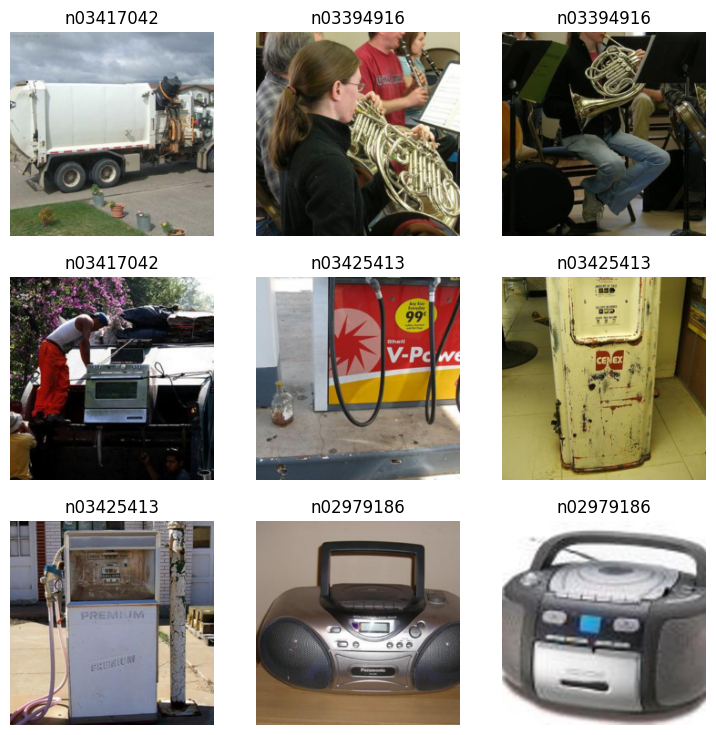

In [3]:
dls = ImageDataLoaders.from_folder(
    path, 
    valid='val',  # Use 'val' folder for validation set
    item_tfms=Resize(224),  # Resize images to 224x224
    batch_tfms=Normalize.from_stats(*imagenet_stats),  # Normalize using ImageNet stats
)
dls.show_batch()

## ResNet18

ResNet18 is a lightweight convolutional neural network from the ResNet (Residual Network) family, designed for efficient image classification. The model can be initialized using FastAI `vision_learner` function, with the option `pretrained=True` to load weights trained on the full ImageNet dataset. Since the pretrained model is designed to classify 1,000 categories, we need to fine-tune it to adapt to Imagenette’s 10 classes.

Fine-tuning adjusts the model’s weights for our specific dataset while leveraging the pretrained features. With FastAI, we achieve this using `fine_tune`:

In [4]:
learn = vision_learner(dls, resnet18, metrics=accuracy, pretrained=True)
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.251737,0.052396,0.981911,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.099738,0.052386,0.982675,01:13


With CUDA on Jetson, training takes just over 1 minute per epoch, achieving 98.3% accuracy quickly. This shows Jetson's GPU acceleration makes it efficient for lightweight deep learning tasks, though speed may vary depending on the Jetson model (Nano, Xavier, Orin) and available GPU memory.

Next, we can inspect the inference results by the fine-tuned model by checking inference of one batch or plotting top losses:

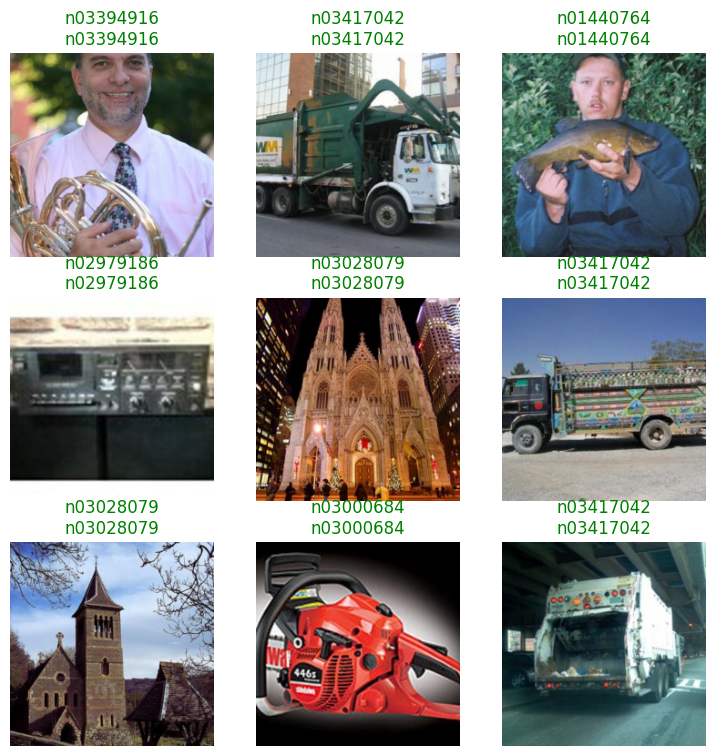

In [5]:
learn.show_results()

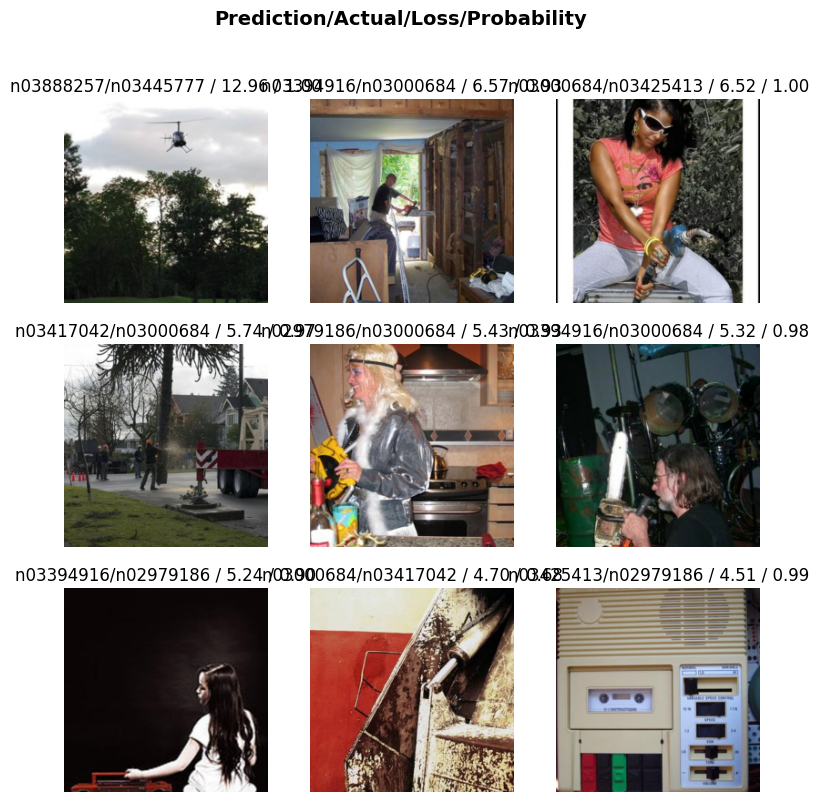

In [6]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

## Application

Once trained, we can use the model to make predictions on new images. FastAI provides an easy `learn.predict()` function, which returns the predicted class, confidence score, and raw probabilities:

/home/jetson/jetson-examples/fastai/data/imagenette2-320/train/n03888257/n03888257_457.JPEG


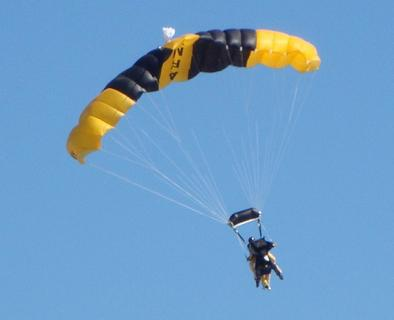

In [7]:
print(train_files[0])  # Image label is the name of its parent folder (n03888257)
Image.open(train_files[0])

In [8]:
# Predict the label of the first image in the training set
pred, pred_idx, probs = learn.predict(train_files[0])
print(f'Prediction: {pred}, Probability: {probs[pred_idx]:.4f}')

Prediction: n03888257, Probability: 1.0000


It is also possible to save and load the model for future usage:

In [9]:
learn.path = Path.cwd() / 'models' # Save model in 'models' folder
learn.export('resnet18.pkl') 

In [10]:
# Load model and test with the previous prediction
learn = load_learner(Path.cwd() / 'models' / 'resnet18.pkl')
learn.predict(train_files[0])  

('n03888257',
 tensor(9),
 tensor([1.1913e-09, 3.4583e-11, 7.4963e-12, 1.0178e-10, 4.9058e-10, 3.6666e-12,
         8.0694e-11, 5.4573e-11, 1.3045e-11, 1.0000e+00]))

## Conclusion

In this guide, we explored training a ResNet18 model on the Imagenette2-320 dataset using FastAI and CUDA on Jetson. We covered dataset preparation, data loading, model fine-tuning, and evaluation. The training process was efficient, achieving high accuracy in just over a minute per epoch. Finally, we discussed saving and loading the trained model for future use, enabling easy deployment on Jetson or other edge devices. 

With this workflow, you can quickly build and fine-tune deep learning models for real-world image classification tasks. To view the full guide from setting up Jetson device and PyTorch to executing this workflow, follow [this link](https://ninjalabo.ai/jetson-examples/fastai.html).